In [1]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torchvision.transforms.functional as TF
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

In [2]:
print(os.listdir("../input/dlp-object-detection/final_dlp_data/final_dlp_data/train"))

['labels', 'images']


In [3]:
print(os.listdir("/kaggle/working/"))

['.virtual_documents']


In [4]:
transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor()
        ])
a = Image.open('/kaggle/input/dlp-object-detection/final_dlp_data/final_dlp_data/train/images/008b8a9c-dae2-4a58-accf-33165472de6e.jpeg').convert("RGB")
a = transform(a)
a.shape

torch.Size([3, 512, 512])

In [5]:
classes = {
"aegypti": 0,
"albopictus": 1,
"anopheles": 2,
"culex": 3,
"culiseta": 4,
"japonicus": 5,
"koreicus": 5
}

def get_mod_label(label):
    one_hot_enc = np.zeros(6)
    remaining = label[1:]
    one_hot_enc[int(label[0])-1] = 1
    return np.concatenate((one_hot_enc, remaining), axis=0)

    
class MosquitoDataset(Dataset):
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor()
        ])
        self.images = os.listdir(image_dir)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx].replace(".jpeg", ".txt"))
        with open(label_path, 'r') as file:
            label = [line.strip().split(" ") for line in file]
            label = [float(x) for x in label[0]]
        image = Image.open(img_path).convert("RGB")
        
        return self.transform(image), get_mod_label(label).reshape(1, 1, 10)
            

In [6]:
classes

{'aegypti': 0,
 'albopictus': 1,
 'anopheles': 2,
 'culex': 3,
 'culiseta': 4,
 'japonicus': 5,
 'koreicus': 5}

In [7]:
DATASET_DIR = '../input/dlp-object-detection/final_dlp_data/final_dlp_data/train/'


In [8]:
train_dataset = MosquitoDataset(DATASET_DIR+'images', DATASET_DIR+'labels')

In [9]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2])

(tensor([[[0.3686, 0.3608, 0.3569,  ..., 0.3216, 0.3333, 0.3294],
         [0.3686, 0.3569, 0.3569,  ..., 0.3216, 0.3294, 0.3294],
         [0.3647, 0.3608, 0.3647,  ..., 0.3176, 0.3216, 0.3216],
         ...,
         [0.7843, 0.7882, 0.7882,  ..., 0.7373, 0.7373, 0.7451],
         [0.7843, 0.7882, 0.7922,  ..., 0.7412, 0.7373, 0.7490],
         [0.7843, 0.7843, 0.7882,  ..., 0.7529, 0.7451, 0.7490]],

        [[0.3490, 0.3412, 0.3412,  ..., 0.3098, 0.3176, 0.3137],
         [0.3529, 0.3412, 0.3412,  ..., 0.3098, 0.3137, 0.3137],
         [0.3490, 0.3451, 0.3451,  ..., 0.3059, 0.3059, 0.3059],
         ...,
         [0.7608, 0.7647, 0.7647,  ..., 0.7255, 0.7255, 0.7333],
         [0.7608, 0.7647, 0.7686,  ..., 0.7294, 0.7255, 0.7373],
         [0.7608, 0.7608, 0.7647,  ..., 0.7412, 0.7333, 0.7373]],

        [[0.3020, 0.2941, 0.2941,  ..., 0.2667, 0.2784, 0.2706],
         [0.3059, 0.2941, 0.2941,  ..., 0.2667, 0.2706, 0.2706],
         [0.3020, 0.3020, 0.3020,  ..., 0.2667, 0.2706, 0

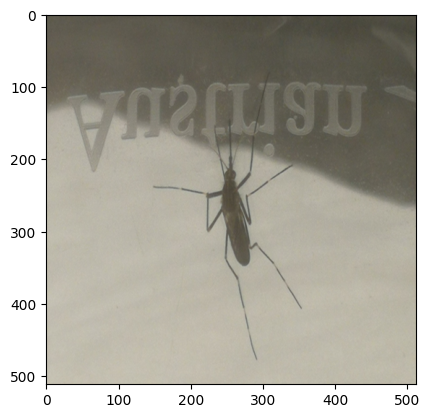

In [67]:
img = train_dataset[100]
print(img)
imgPIL = img[0].permute(1,2,0)
imgPIL.size()
plt.imshow(imgPIL.numpy())


In [11]:
img[1]

array([[[0.        , 0.        , 1.        , 0.        , 0.        ,
         0.        , 0.45833333, 0.520625  , 0.14      , 0.1825    ]]])

In [12]:
os.cpu_count()

4

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    NUM_WORKERS = torch.cuda.device_count() * min(4, os.cpu_count())
else: 
    NUM_WORKERS = min(4, os.cpu_count())

In [14]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 8
PIN_MEMORY = False
SHUFFLE = True

In [15]:
from functools import partial

setup_dataloader = partial(DataLoader, 
                           num_workers=NUM_WORKERS,
                           pin_memory=PIN_MEMORY,
                           batch_size=BATCH_SIZE,
                           shuffle=SHUFFLE
                          )

In [16]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, filter_size):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, filter_size, 1, 1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    def forward(self, x):
        return self.block(x)
        
class YOLO(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(YOLO, self).__init__()
        self.net = nn.Sequential(
            ConvBlock(in_channel, 4, 3),
            ConvBlock(4, 8, 3),
            ConvBlock(8, 16, 5),
            ConvBlock(16, 8, 10),
            ConvBlock(8, 1, 10),
            nn.Conv2d(1, 1, kernel_size=(10, 1), stride=1)
        )
    def forward(self, x):
        return self.net(x)
        

In [17]:
model = YOLO(3, 1).to(device)
model

YOLO(
  (net): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(i

In [18]:
def test():
    inp = torch.randn((10, 3, 512, 512))
    model = YOLO(3, 1)
    out = model(inp)
    print(inp.shape)
    print(out.shape)

test()

torch.Size([10, 3, 512, 512])
torch.Size([10, 1, 1, 10])


In [19]:
import torch.nn.functional as F

class YoloCombinedLoss(nn.Module):
    def __init__(self, bce_weight=1.0, mse_weight=1.0):
        super(YoloCombinedLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss() # Use BCEWithLogitsLoss for numerical stability
        self.mse_loss = nn.MSELoss()
        self.bce_weight = bce_weight
        self.mse_weight = mse_weight

    def forward(self, output, target):
        # Squeeze dimensions to (m, 10) for easier indexing if necessary,
        # but BCEWithLogitsLoss and MSELoss can handle the 1,1,1 dimensions if consistent.
        # Let's assume output and target are already (m, 10) after potential squeezing
        # or we handle the slicing with the extra dimensions.
        
        # Original shape: (m, 1, 1, 10)
        # We need to reshape to (m, 10) for easier slicing.
        # .squeeze(-2).squeeze(-2) removes the dimensions of size 1 at index -2 and -3.
        # Or, you can explicitly reshape: .view(output.shape[0], -1)
        # print(f"""
        # !!!!!!!!!!!!!!!!!
        # {output.shape}
        # {target.shape}
        # !!!!!!!!!!!!!!!!
        # """)
        output_flat = output.squeeze(-2).squeeze(-2) # Becomes (m, 10)
        target_flat = target.squeeze(-2).squeeze(-2) # Becomes (m, 10)
        
        # Extract the first 6 elements for BCE
        output_bce = output_flat[:, :6]
        target_bce = target_flat[:, :6]

        # Extract the last 4 elements for MSE
        output_mse = output_flat[:, 6:]
        target_mse = target_flat[:, 6:]

        # Calculate BCE Loss
        # BCEWithLogitsLoss expects 'logits' (raw output before sigmoid) for output.
        # Target should be floats (0.0 or 1.0).
        bce_part = self.bce_loss(output_bce, target_bce)

        # Calculate MSE Loss
        mse_part = self.mse_loss(output_mse, target_mse)

        # Combine the losses with weights
        total_loss = (self.bce_weight * bce_part) + (self.mse_weight * mse_part)

        return total_loss

In [20]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = YoloCombinedLoss()
torch.cuda.empty_cache()

train_dataloader = setup_dataloader(dataset=train_dataset)
test_dataloader = setup_dataloader(dataset=test_dataset)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [21]:
def train_yolo(epochs):
    EPOCHS = epochs

    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(EPOCHS)):
        model.train()
        train_running_loss = 0
        
        for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
            img = img_label[0].float().to(device)
            label = img_label[1].float().to(device)
            
            y_pred = model(img)
            optimizer.zero_grad()            
            loss = criterion(y_pred, label)
            
            train_running_loss += loss.item()
    
            loss.backward()
            optimizer.step()
    
        train_loss = train_running_loss / (idx + 1)
        
        train_losses.append(train_loss)
    
        model.eval()
        val_running_loss = 0
        
        with torch.no_grad():
            for idx, img_label in enumerate(tqdm(test_dataloader, position=0, leave=True)):
                img = img_label[0].float().to(device)
                label = img_label[1].float().to(device)
    
                y_pred = model(img)
                loss = criterion(y_pred, label)
                
                val_running_loss += loss.item()
    
            val_loss = val_running_loss / (idx + 1)
        
        val_losses.append(val_loss)
    
        print("-" * 30)
        print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
        print("\n")
        print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
        print("-" * 30)
    
    # Saving the model
    torch.save(model.state_dict(), 'my_checkpoint.pth')
    return train_losses, val_losses

In [22]:
EPOCHS = 5
train_losses, val_losses = train_yolo(EPOCHS)

 23%|██▎       | 169/750 [01:00<03:22,  2.88it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 81%|████████  | 608/750 [03:24<00:38,  3.66it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 20%|██        | 1/5 [05:15<21:01, 315.44s/it]

------------------------------
Training Loss EPOCH 1: 0.7901


Validation Loss EPOCH 1: 0.7603
------------------------------


  5%|▍         | 35/750 [00:13<03:45,  3.17it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 71%|███████   | 531/750 [02:47<00:42,  5.11it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 40%|████      | 2/5 [10:10<15:11, 303.68s/it]

------------------------------
Training Loss EPOCH 2: 0.7519


Validation Loss EPOCH 2: 0.7424
------------------------------


  1%|          | 5/750 [00:03<07:16,  1.71it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
  6%|▌         | 46/750 [00:18<02:22,  4.95it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 60%|██████    | 3/5 [15:02<09:56, 298.33s/it]

------------------------------
Training Loss EPOCH 3: 0.7392


Validation Loss EPOCH 3: 0.7312
------------------------------


 32%|███▏      | 242/750 [01:20<02:37,  3.23it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 80%|████████  | 4/5 [19:53<04:55, 295.48s/it]

------------------------------
Training Loss EPOCH 4: 0.7310


Validation Loss EPOCH 4: 0.7326
------------------------------


 46%|████▌     | 344/750 [01:53<01:20,  5.07it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
 56%|█████▌    | 417/750 [02:18<02:12,  2.52it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 5/5 [24:50<00:00, 298.06s/it]

------------------------------
Training Loss EPOCH 5: 0.7266


Validation Loss EPOCH 5: 0.7249
------------------------------


In [70]:
import matplotlib.patches as patches

def diplay_with_bb(img, name="Image with Bounding Box"):
    image_display = np.transpose(img[0], (1, 2, 0)) # (512, 512, 3)
    
    # Ensure data type and range are suitable for matplotlib imshow
    # If your image_np is float, it should be in [0.0, 1.0]
    # If your image_np is integer, it should be in [0, 255] (uint8)
    # If it's outside this range or wrong dtype, imshow might clip or display incorrectly.
    # Example: If your tensor was output by a model and has negative values or values > 1,
    # you might need to clip or normalize:
    # image_display = np.clip(image_display, 0, 1) # For float images
    # image_display = (image_display * 255).astype(np.uint8) # For uint8 images if it was float [0,1]
    
    # --- 3. Display Image and Bounding Box ---
    
    fig, ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(image_display)
    
    # Create a Rectangle patch
    # (x, y) is the bottom-left corner of the rectangle
    # width = x_max - x_min
    # height = y_max - y_min
    bounding_box = img[1][0][0][6:] * 512
    print(img[0].shape)
    print(bounding_box)
    rect = patches.Rectangle(
        (bounding_box[0], bounding_box[1]),
        bounding_box[2],
        bounding_box[3],
        linewidth=2,
        edgecolor='r',  # Red color for the box
        facecolor='none' # No fill
    )
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    # Add title and remove axis ticks
    ax.set_title(name)
    ax.axis('off') # Hide axes ticks and labels
    
    plt.show()

(tensor([[[0.3686, 0.3608, 0.3569,  ..., 0.3216, 0.3333, 0.3294],
         [0.3686, 0.3569, 0.3569,  ..., 0.3216, 0.3294, 0.3294],
         [0.3647, 0.3608, 0.3647,  ..., 0.3176, 0.3216, 0.3216],
         ...,
         [0.7843, 0.7882, 0.7882,  ..., 0.7373, 0.7373, 0.7451],
         [0.7843, 0.7882, 0.7922,  ..., 0.7412, 0.7373, 0.7490],
         [0.7843, 0.7843, 0.7882,  ..., 0.7529, 0.7451, 0.7490]],

        [[0.3490, 0.3412, 0.3412,  ..., 0.3098, 0.3176, 0.3137],
         [0.3529, 0.3412, 0.3412,  ..., 0.3098, 0.3137, 0.3137],
         [0.3490, 0.3451, 0.3451,  ..., 0.3059, 0.3059, 0.3059],
         ...,
         [0.7608, 0.7647, 0.7647,  ..., 0.7255, 0.7255, 0.7333],
         [0.7608, 0.7647, 0.7686,  ..., 0.7294, 0.7255, 0.7373],
         [0.7608, 0.7608, 0.7647,  ..., 0.7412, 0.7333, 0.7373]],

        [[0.3020, 0.2941, 0.2941,  ..., 0.2667, 0.2784, 0.2706],
         [0.3059, 0.2941, 0.2941,  ..., 0.2667, 0.2706, 0.2706],
         [0.3020, 0.3020, 0.3020,  ..., 0.2667, 0.2706, 0

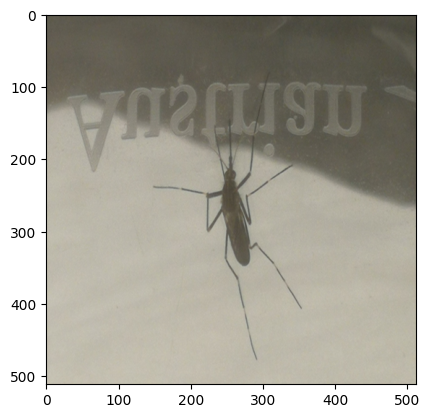

In [91]:
img = train_dataset[100]
print(img)
imgPIL = img[0].permute(1,2,0)
imgPIL.size()
plt.imshow(imgPIL.numpy())

torch.Size([3, 512, 512])
[253.67741935 285.16129032 218.06451613 373.84946237]


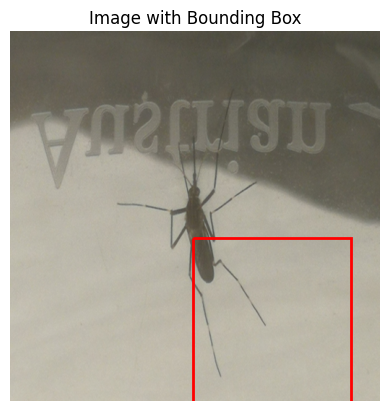

In [92]:
diplay_with_bb(img)

torch.Size([3, 512, 512])
tensor([152.2448, 173.9957, 205.8346, 161.1875])


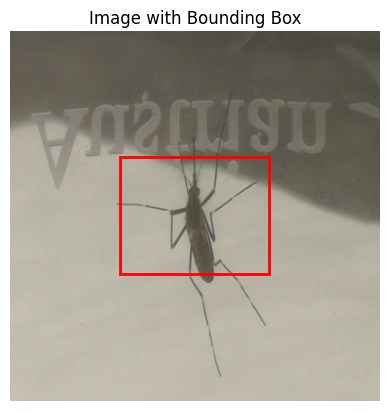

In [93]:
pred = model(img[0].reshape(1,3,512,512).to(device))
diplay_with_bb((img[0], pred[0].cpu().detach()))